In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import layers, models, regularizers, activations
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.models import model_from_json
from tensorflow.keras.utils import to_categorical
from keras.models import load_model


import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
# Chars74k dataset
all_data = []
all_labels = []

for idx, elem in enumerate(os.listdir('dataset_nums')):
    for idx2, elem2 in enumerate(os.listdir('dataset_nums/' + elem)):
        curr_img = cv2.imread('dataset_nums/' + elem + '/' +  elem2)
        curr_img = cv2.cvtColor(curr_img, cv2.COLOR_BGR2GRAY)         # Convert Images to Grayscale
        curr_img = cv2.resize(curr_img,(28,28))   #resize
        curr_img = 255 - curr_img   # turn black on white to white on black
        all_data.append(curr_img)
        all_labels.append(idx)

all_data = np.array(all_data)
all_labels = np.array(all_labels)

In [3]:
# MNIST dataset
(X_train_mnist, y_train_mnist), (X_test_mnist, y_test_mnist) = tf.keras.datasets.mnist.load_data()

# sample 6000 randomly from train mnist
np.random.seed(42)
random_idx = np.random.choice(len(X_train_mnist), size=6000, replace=False)
X_train_mnist_sample = X_train_mnist[random_idx]
y_train_mnist_sample = y_train_mnist[random_idx]

all_data = np.vstack((all_data, X_train_mnist_sample))
all_labels = np.concatenate((all_labels, y_train_mnist_sample))

In [4]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(all_data, all_labels, test_size=0.2, random_state=42)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

X_train = X_train.reshape(-1,28,28,1)
X_test = X_test.reshape(-1,28,28,1)

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

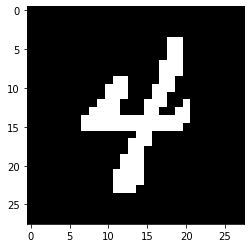

In [7]:
# threshold binarization
X_train = [cv2.threshold(elem,100, 255, cv2.THRESH_BINARY)[1] for elem in X_train]
X_test = [cv2.threshold(elem,100, 255, cv2.THRESH_BINARY)[1] for elem in X_test]

X_train = np.array(X_train).reshape(-1,28,28,1)
X_test = np.array(X_test).reshape(-1,28,28,1)

# rescale by divining all by 255
X_train_resized = X_train / 255
X_test_resized = X_test / 255

#resized_image = cv2.resize(X_train[0], (21, 21)) 
plt.imshow(X_train_resized[0,:,:,0], 'gray')

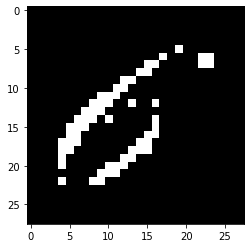

In [8]:
plt.imshow(X_test_resized[1,:,:,0], 'gray')

In [9]:
# create image data generator
train_datagen = ImageDataGenerator(
    #rescale=1./255,
    #featurewise_center = True,
    #featurewise_std_normalization = True, 
    #shear_range=0.2,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    rotation_range = 10,
    zoom_range=0.1,
    #horizontal_flip=True,
    vertical_flip=True)

#test_datagen = ImageDataGenerator(rescale=1./255)

# create train data generator
train_generator = train_datagen.flow(
    x=X_train_resized,
    y=y_train,
    batch_size=128,
    shuffle=True,
    sample_weight=None,
    seed=42,
    save_to_dir=None,
    save_prefix="",
    subset=None)

In [10]:
model = keras.Sequential()

model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(units=120, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(units=84, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(units=10, activation = 'softmax'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1600)              6

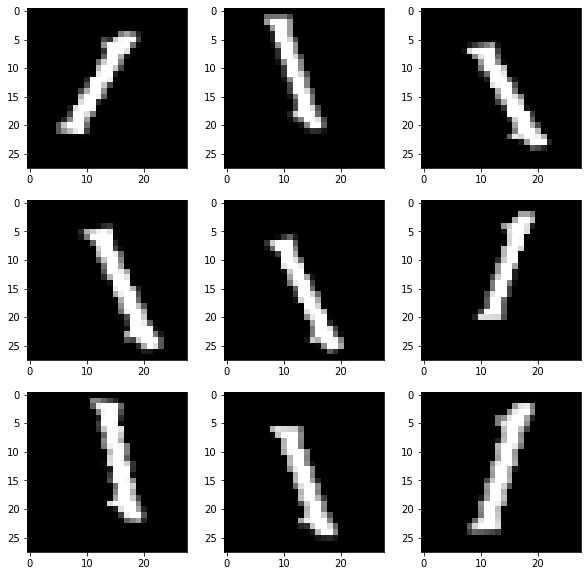

In [12]:
i = 0
plt.figure(figsize=(10,10))

test_img = X_test_resized[0].reshape(1,28,28,1)

train_datagen.fit(test_img, augment = True)

for img_batch in train_datagen.flow(test_img, batch_size=9):
    for img in img_batch:        
        ax = plt.subplot(3,3 ,i+1)
        im = ax.imshow(img[:,:,0], 'gray')
        i = i + 1
        
    if i >= 9:
        break

In [13]:
# early stopping
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='auto', restore_best_weights=True)

# learning rate scheduler
def scheduler(epoch):
    if epoch < 10:
        return 0.001
    else:
        return 0.001 * tf.math.exp(0.1 * (10 - epoch))

    
#variable_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor = 0.2, patience = 2)
    
# list of callbacks
callbacks_list = [earlystop, LearningRateScheduler(scheduler)]

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
# fit model
history = model.fit(
      x = train_generator,
      #x = X_train_resized,
      #y = y_train,
      batch_size = 128,
      epochs=100,
      validation_data = (X_test_resized, y_test),
      verbose=1,
      callbacks=callbacks_list)

Epoch 1/100
101/101 [==============================] - 19s 188ms/step - loss: 0.3005 - accuracy: 0.9141 - val_loss: 1.7506 - val_accuracy: 0.1965 - lr: 0.0010
Epoch 2/100
101/101 [==============================] - 21s 206ms/step - loss: 0.0608 - accuracy: 0.9858 - val_loss: 1.3751 - val_accuracy: 0.4131 - lr: 0.0010
Epoch 3/100
101/101 [==============================] - 21s 211ms/step - loss: 0.0276 - accuracy: 0.9940 - val_loss: 0.7591 - val_accuracy: 0.7506 - lr: 0.0010
Epoch 4/100
101/101 [==============================] - 21s 209ms/step - loss: 0.0145 - accuracy: 0.9973 - val_loss: 0.2214 - val_accuracy: 0.9604 - lr: 0.0010
Epoch 5/100
101/101 [==============================] - 21s 209ms/step - loss: 0.0082 - accuracy: 0.9987 - val_loss: 0.0833 - val_accuracy: 0.9817 - lr: 0.0010
Epoch 6/100
101/101 [==============================] - 21s 211ms/step - loss: 0.0060 - accuracy: 0.9993 - val_loss: 0.0495 - val_accuracy: 0.9855 - lr: 0.0010
Epoch 7/100
101/101 [=========================

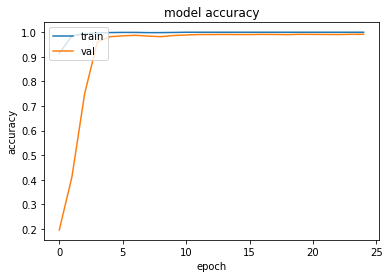

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

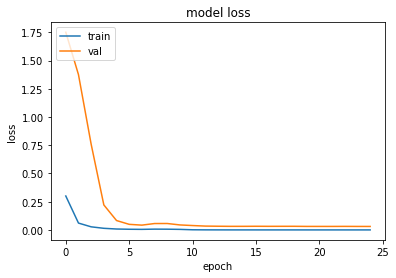

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [15]:
def do_prediction(model, data):
    y_pred = []

    for ind, elem in enumerate(data):
        pred = model.predict_classes(data[ind:ind+1,:,:,:])
        y_pred.append(pred[0])
    
    return y_pred

y_pred = do_prediction(model, X_test_resized)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [16]:
y_test_true = np.argmax(y_test, axis=1)
print('Accuracy Score: ', accuracy_score(y_test_true, y_pred))

Accuracy Score:  0.9894


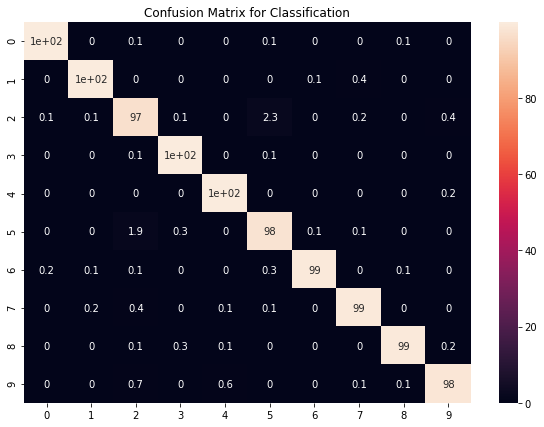

In [17]:
def generate_conf_mat_df(y_true, y_pred, normalize = 'true'):
    conf_mat = confusion_matrix(y_true, y_pred, normalize = normalize)
    df_cm = pd.DataFrame(conf_mat, index = [i for i in list(range(10))],
                  columns = [i for i in list(range(10))])

    df_cm = df_cm * 100
    df_cm = df_cm.round(1)
    return df_cm

df_cm = generate_conf_mat_df(y_test_true, y_pred)

plt.figure(figsize = (10,7))
plt.title('Confusion Matrix for Classification')
sns.heatmap(df_cm, annot=True)

In [18]:
# save model as hdf5 file
model.save('digit_recognizer.h5')

In [19]:
model2 = tf.keras.models.load_model('digit_recognizer.h5')
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1600)              6

In [20]:
model2.predict_classes(X_test_resized[0:1,:,:,:])[0]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


1

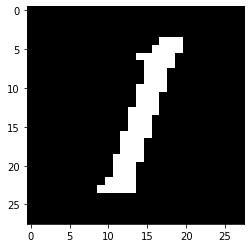

In [22]:
plt.imshow(X_test_resized[0:1,:,:,0].reshape(28,28), 'gray')